## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
from keras.layers import BatchNormalization, Activation, Dropout
from keras import regularizers
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, kernel_regularizer=regularizers.l2(0.01),
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                # x = Dropout(0.5)(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                # x = Dropout(0.5)(x)
        else:
            x = keras.layers.Dense(units=n_units, kernel_regularizer=regularizers.l2(0.01),
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                # x = Dropout(0.5)(x)
            else:
                x = BatchNormalization()(x)
                # x = Dropout(0.5)(x)
                x = Activation("relu")(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
#BATCH_SIZE = [2, 16, 32, 128]
BATCH_SIZE = [32, 128]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95

In [10]:
results = {}
"""
Write your training loop and record results
"""
for i, (use_preact, bz) in enumerate(itertools.product(PRE_ACTIVATE, BATCH_SIZE)):
    print("Numbers of exp: %i, use_preact: %s, batch_size: %i" % (i, use_preact, bz))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=use_preact)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bz, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, use_preact: True, batch_size: 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (B

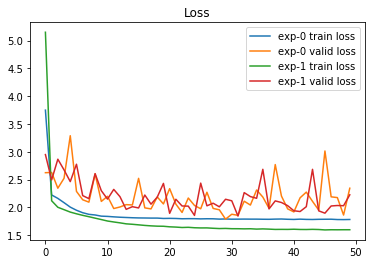

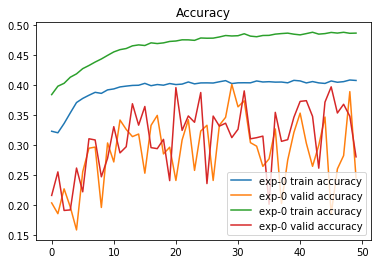

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
Plot results
"""
plt.plot(range(len(results['exp-0']['train-loss'])), results['exp-0']['train-loss'], label="exp-0 train loss")
plt.plot(range(len(results['exp-0']['valid-loss'])), results['exp-0']['valid-loss'], label="exp-0 valid loss")
plt.plot(range(len(results['exp-1']['train-loss'])), results['exp-1']['train-loss'], label="exp-1 train loss")
plt.plot(range(len(results['exp-1']['valid-loss'])), results['exp-1']['valid-loss'], label="exp-1 valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(results['exp-0']['train-acc'])), results['exp-0']['train-acc'], label="exp-0 train accuracy")
plt.plot(range(len(results['exp-0']['valid-acc'])), results['exp-0']['valid-acc'], label="exp-0 valid accuracy")
plt.plot(range(len(results['exp-1']['train-acc'])), results['exp-1']['train-acc'], label="exp-0 train accuracy")
plt.plot(range(len(results['exp-1']['valid-acc'])), results['exp-1']['valid-acc'], label="exp-0 valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()